<img align="center" src="https://raw.githubusercontent.com/FUlyankin/Parsers/master/images%20/cats.jpg" height="1200" width="1200"> 

# Домашка №5: регрессия

Давайте выясним, как профиль вк помогает нам предугадывать число лайков студента первого курса в вышкинском паблике с мемасами.

По ходу кода ниже будет довольно много пустых строк. Нужно заполнить их своим кодом.

In [1]:
import pandas as pd               # уже знакомый вам пакет для работы с таблицами
import numpy as np                # смутно знакомый вам пакет для работы с матрицами
import matplotlib.pyplot as plt   # уже смутно знакомый вам пакет для картинок :3
import seaborn as sns             # ещё один пакет для картинок 
plt.style.use('ggplot')     # правильный (очень красивый) стиль у графиков

%matplotlib inline

Полезная функция для визуализации результатов модели.

In [2]:
# Функция для визуализации прогнозов 

def plot_yreal_ypred(y_test, y_train, X_test, X_train, model, margin=0.3):
    """
        Рисует картинку для прогнозов
            modelt - модель 
            y_train, X_train - обучающая выборка
            y_test, X_test - тестовая выборка
            margin - граница рисунка 
    """
    
    plt.figure(figsize=(16,7))
    plt.subplot(121)
    plt.scatter(y_train, model.predict(X_train), color="red", alpha=1)
    plt.xlim(min(y_train) - margin, max(y_train) + margin)
    plt.ylim(min(y_train) - margin, max(y_train) + margin)
    plt.title('Train set', fontsize=20)
    plt.xlabel('y', fontsize=14)
    plt.ylabel('Estimated y', fontsize=14)

    plt.subplot(122)
    plt.scatter(y_test, model.predict(X_test), color="red", alpha=1)
    plt.xlim(min(y_test) - margin, max(y_test) + margin)
    plt.ylim(min(y_test) - margin, max(y_test) + margin)
    plt.title('Test set', fontsize=20)
    plt.xlabel('y', fontsize=14)
    plt.ylabel('Estimated y', fontsize=14)
    pass

На семинаре мы разобрали пример с рейтингами видеоконтента. Давайте вспомним, какие шаги мы проходили:

1. Обрабатываем данные
2. Строим константный прогноз
3. Строим линейную регрессию c MSE в качестве функции ошибки
4. Находим лучшие гиперпараметры по сетке и строим случайный лес
5. Сравниваем качество прогнозов и делаем выводы


Подгружаем данные.

In [3]:
df = pd.read_csv('../data/vk_main.csv', sep='\t')   # подгружаем датасет
print('Размерность таблицы:', df.shape)   
df.head()

Размерность таблицы: (425, 98)


,city,country,first_name,home_town,in_hse_memes_group,is_bmm,is_closed,last_name,likes_memes,uid,...,photo_month_mean,photo_repost_cnt,photo_repost_max,photo_repost_mean,photo_repost_median,photo_text_len_cnt,photo_ava_change_cnt,photo_text_url_len_cnt,friends_from_course_cnt,friends_mail_from_course_pct
0,Москва,Россия,Александра,Москва,True,True,False,Абашкова,60.0,182152789,...,1.333333,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,42.0,0.428571
1,Рязань,Россия,Анастасия,Рязань,True,True,False,Чуфистова,0.0,148020433,...,2.375000,2.0,1.0,0.105263,0.0,0.0,0.0,0.0,32.0,0.281250
2,Москва,Россия,Александр,Омск,False,True,False,Головачев,0.0,138413935,...,1.400000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,32.0,0.406250
3,NaN,NaN,Анна,NaN,False,True,False,Лобанова,0.0,366261055,...,4.166667,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,45.0,0.333333
4,NaN,Россия,Алексей,NaN,True,True,False,Пузырный,21.0,111252392,...,3.181818,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,41.0,0.341463


# 1. Смотрим на данные

Давайте посмотрим на наши переменные. Начнем с нашей предсказываемой переменной, числа лайков.

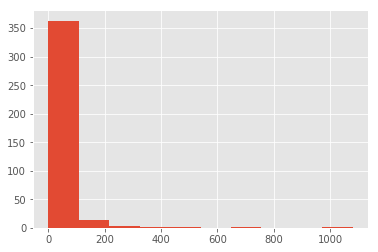

In [4]:
df.likes_memes.hist();

Мы видим тяжелый хвост. В данных куча выбросов. Мы уже умеем с этим бороться. 

__[0.5] Прологарифмируйте переменную и постройте для её логарифма гистограмму.__

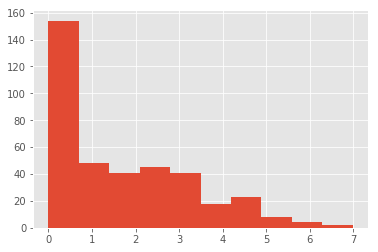

In [5]:
df['ln_likes_memes'] = df['likes_memes'].apply(lambda w: np.log(w + 1))
df.ln_likes_memes.hist()

Помните, в прошлый раз мы сталкивались с пропусками в данных? Давайте посмотрим, что насколько полные в этом плане у нас данные. 
Визуализируем табличку данных, раскрасим желтым цветом пропуски, фиолетовым - наблюдения. 

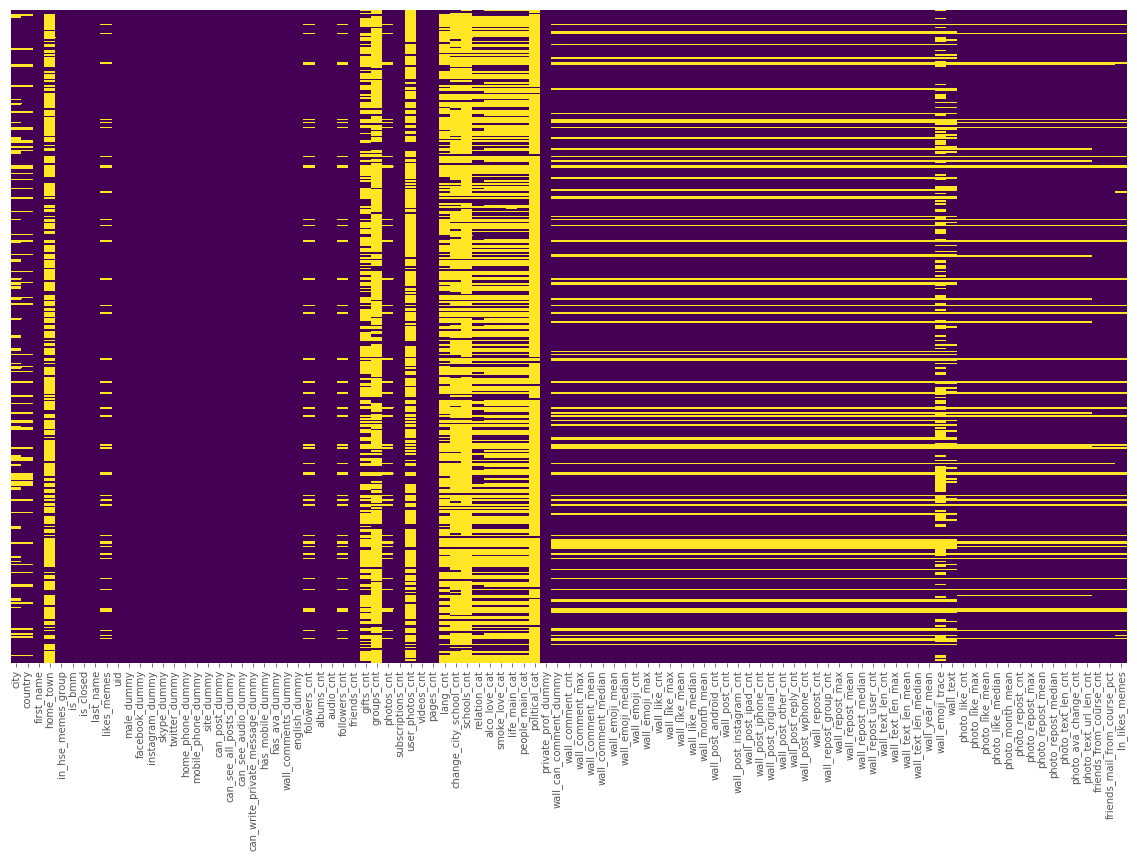

In [6]:
fig, ax = plt.subplots(figsize=(20,12))
sns_heatmap = sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

У нас есть целые столбцы желтого цвета, т.е. они не несут для нас информации (они же пустые). Очень большое число пропусков связано с приватностью странички (таких $82$). Давайте выкинем из рассмотрения все данные, где пропусков строго больше $82$ и все наблюдения, где предсказываемая переменная пустая. 

__[1] Сделайте это :)__

In [7]:
print('Переменных до выбрасывания:', df.shape)

isnull = df.isnull().sum()

df = df[isnull[isnull <= 82].index]


df = df[(df.ln_likes_memes.isnull() == False)]

print('Переменных после выбрасывания:', df.shape)

Переменных до выбрасывания: (425, 99)
Переменных после выбрасывания: (384, 83)


Все переменные, которые есть в выборке делятся на несколько типов. Я специально постарался отразить их типы в названиях. Давайте посмотрим на то, какие это типы.

## 1.1 Переменные счётчики
Количество друзей, количество подписчиков, число фоток - всё это счётчики!

In [8]:
variables_cnt = [item for item in df.columns if item[-3:] == 'cnt']
variables_cnt[:5]

['folowers_cnt', 'albums_cnt', 'audio_cnt', 'followers_cnt', 'friends_cnt']

Давайте их визуализируем.

__[0.5] Постройте гистограммы для всех счётчиков__

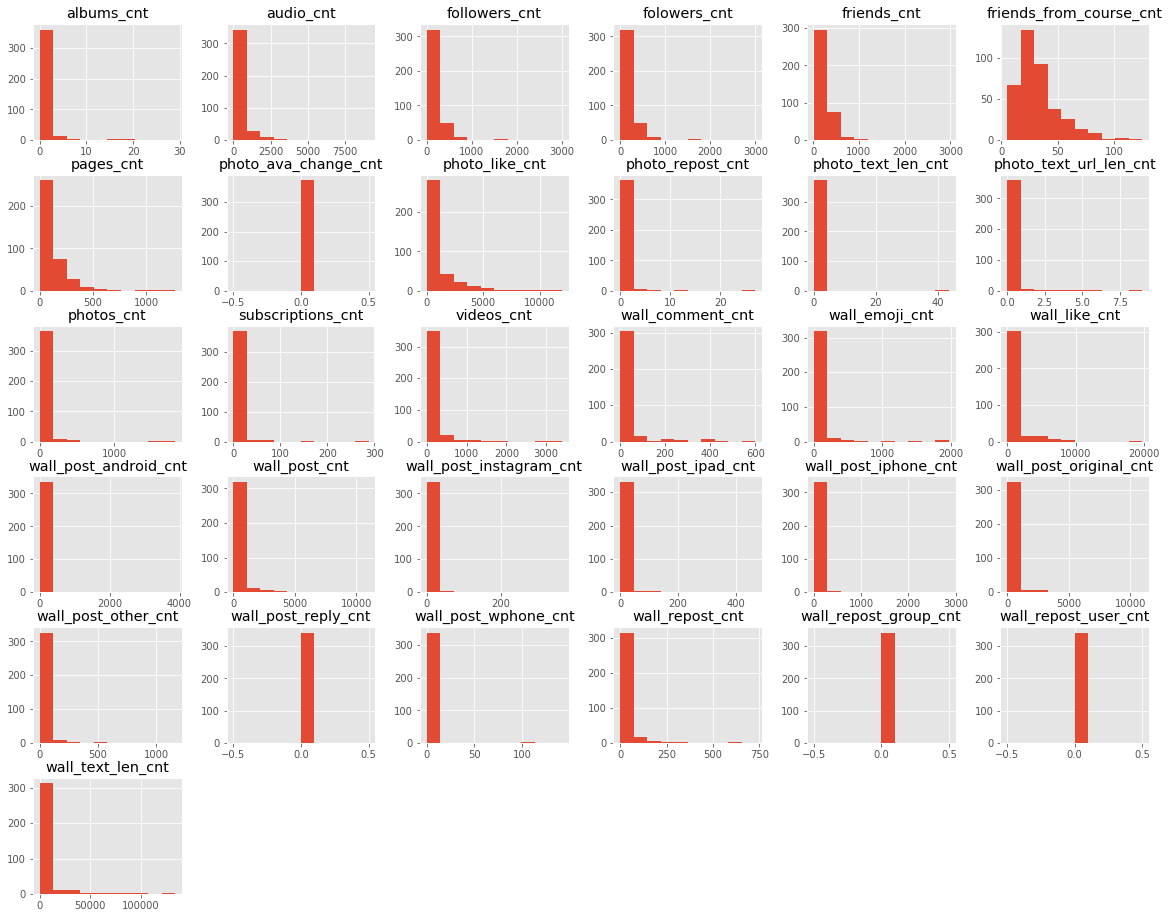

In [9]:
# Ваша одна строчка кода 
df[variables_cnt].hist(figsize=(20,16));

Видим две вещи: 

* У многих счётчиков длинные хвосты => выбросы => придется их сглаживать.
* Многие счётчики не очень информативны: принимают одно или два значения => придется такие счётчики выбросить. 

In [10]:
print('Переменных-счётчиков до отбрасывания:', len(variables_cnt))

# Оставим только те счётчики, которые принимают больше 10 значений 
variables_cnt = [item for item in variables_cnt if len(df[item].unique()) > 10]

print('Переменных-счётчиков после отбрасывания:', len(variables_cnt))

Переменных-счётчиков до отбрасывания: 31
Переменных-счётчиков после отбрасывания: 23


Многие оставшиеся перемннные имеют тяжелые хвосты. Что мы с ними делаем? Правильно! Логарифмируем. 

__[1] Прологарифмируйте все счётчики и снова постройте для них гистограммы.__

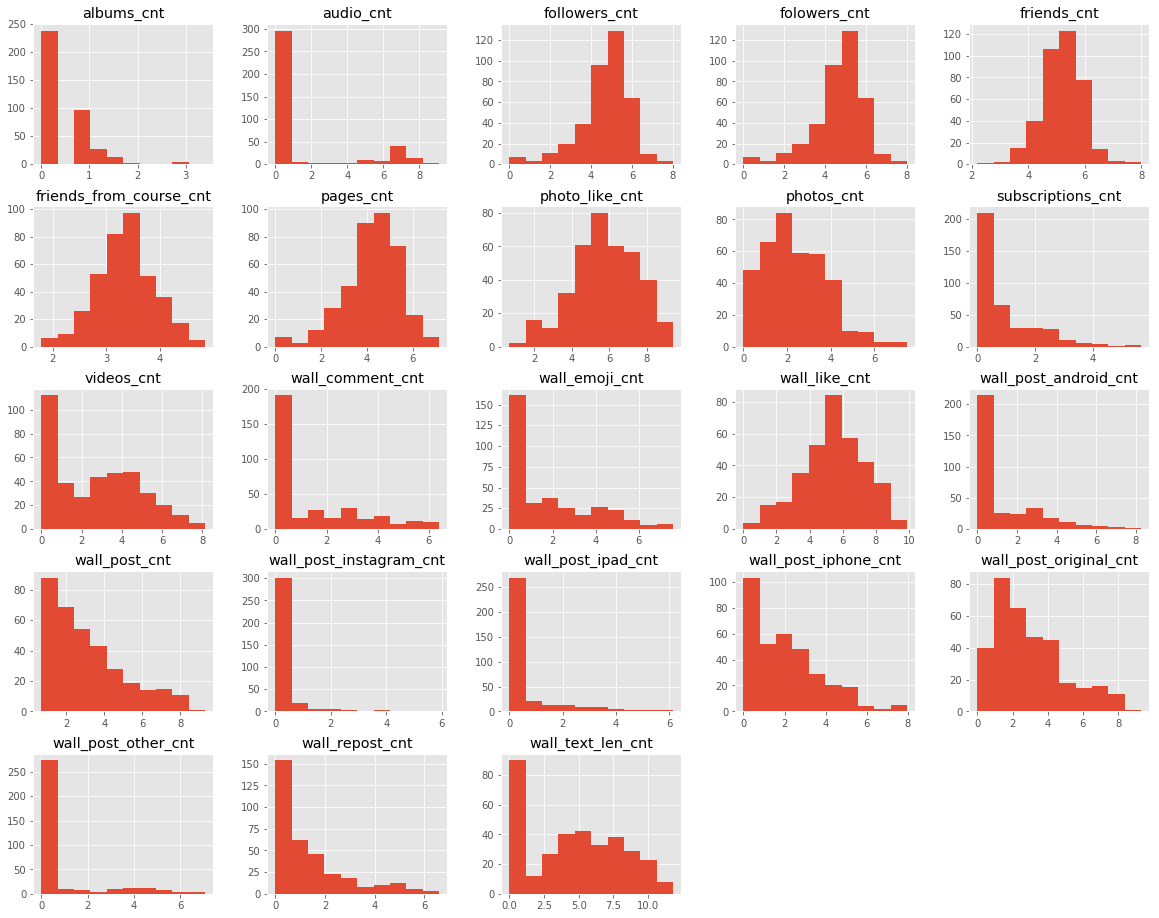

In [11]:
df[variables_cnt] = df[variables_cnt].apply(lambda w: np.log(w + 1))
df[variables_cnt].hist(figsize=(20,16));

## 1.2 Dummy - переменные
 
У нас также есть переменные, принимающие значения 0 или 1, давайте на них посмотрим.

In [12]:
variables_dummy = [item for item in df.columns if item[-5:] == 'dummy']
variables_dummy[:5]

['male_dummy',
 'facebook_dummy',
 'instagram_dummy',
 'skype_dummy',
 'twitter_dummy']

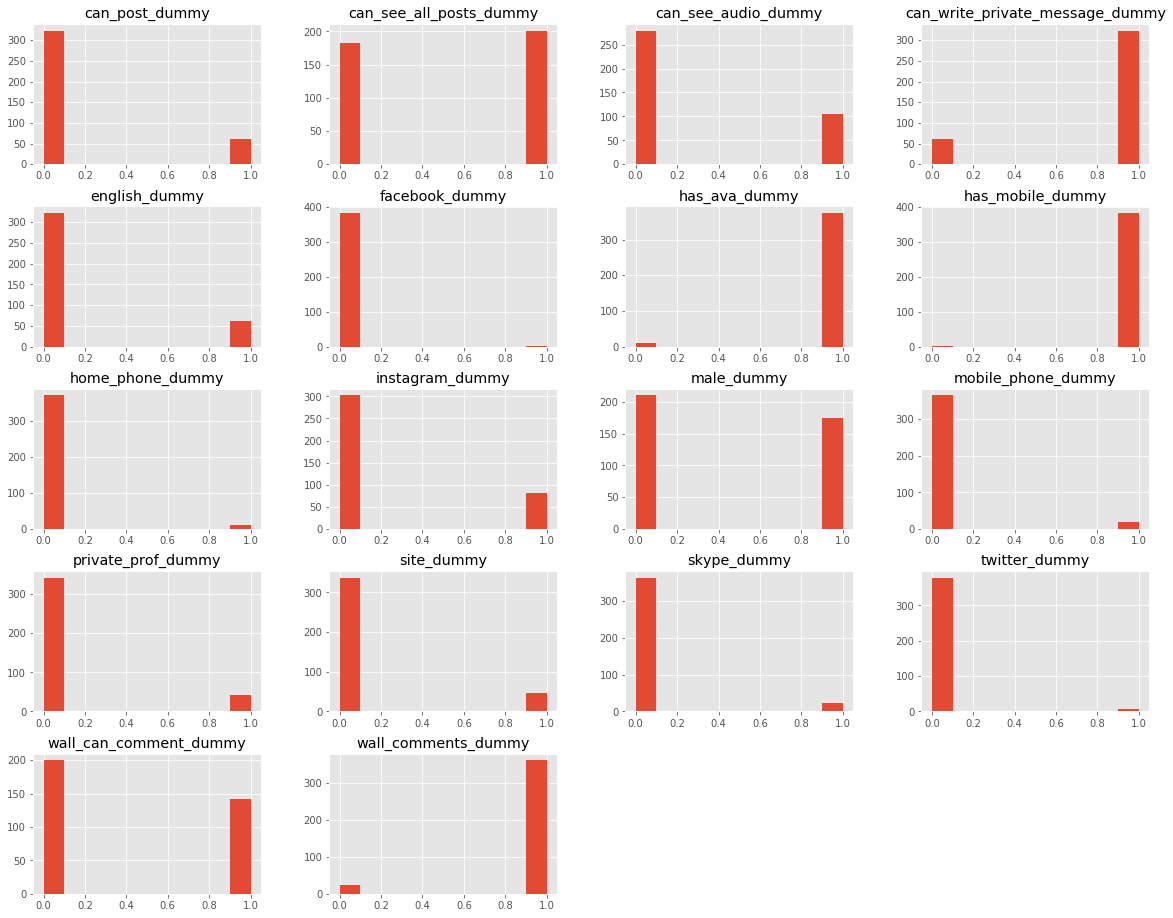

In [13]:
df[variables_dummy].hist(figsize=(20,16));

Есть несколько не очень информативных переменных. Например, наличие твиттера или указан ли телефон. Почти у всех там стоят нули. То есть твиттер и телефон не указаны. Можно было бы выкинуть эти переменные, но мы пожалуй не будем. 

## 1.3 Средние и медианы

Мы посчитали по каждому пользователю среднее число комментов на стене, среднее количество репостов, эмодзи и другие подобные характеристики. Давайте на них взглянем.

In [15]:
variables_mean = [item for item in df.columns if item[-4:] == 'mean']
variables_mean[:5]

['wall_comment_mean',
 'wall_emoji_mean',
 'wall_like_mean',
 'wall_month_mean',
 'wall_repost_mean']

In [16]:
variables_median = [item for item in df.columns if item[-6:] == 'median']
variables_median[:5]

['wall_comment_median',
 'wall_emoji_median',
 'wall_like_median',
 'wall_repost_median',
 'wall_text_len_median']

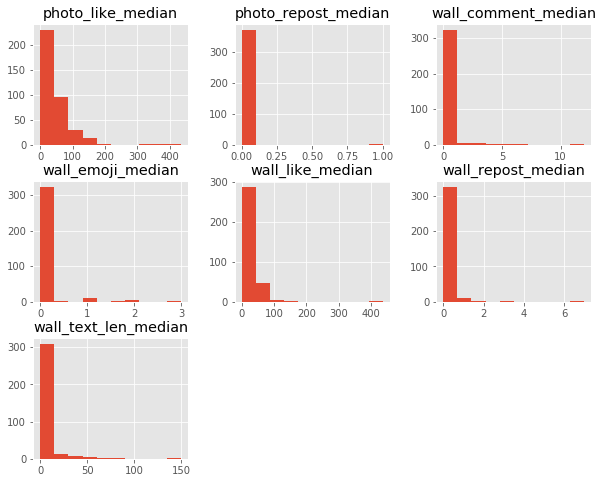

In [17]:
df[variables_median].hist(figsize=(10,8));

Как мы знаем, медиана и среднее могут быть сильно коррелированы, что плохо отражается на линейных моделях регрессии. Давайте посмотрим на матрицу корреляции и выберем один из способов агрегации.

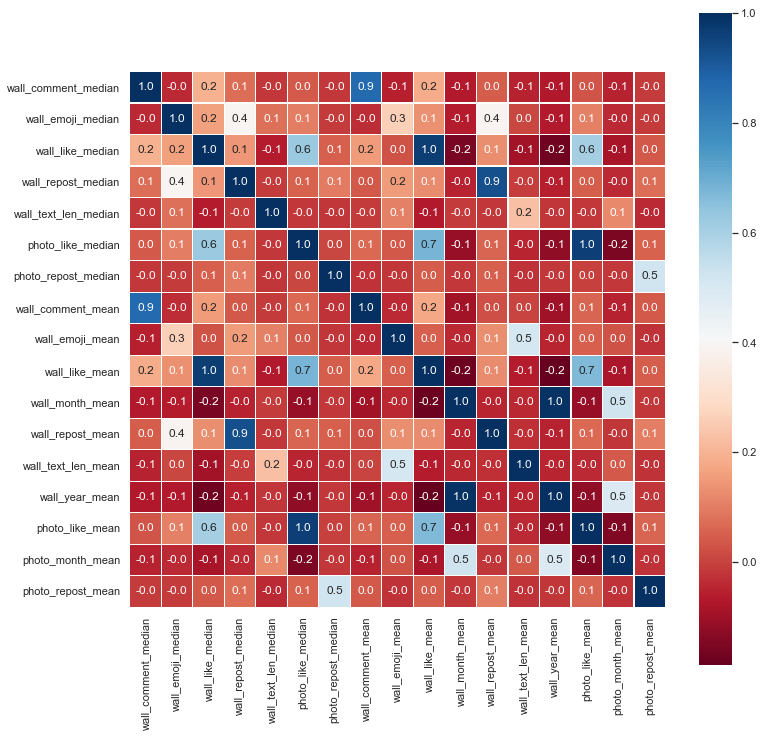

In [18]:
sns.set(font_scale=1)
plt.subplots(figsize=(12, 12))
sns.heatmap(df[variables_median + variables_mean].corr(), square=True,
              annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

Давайте оставим медианы.

In [19]:
variables_descriptive = variables_median 
df[variables_descriptive] =  df[variables_descriptive].apply(lambda w: np.log(w + 1))

Соберем все оставшиеся переменные и заполним пропуски нулями.

In [20]:
useful_variables = variables_cnt + variables_dummy + variables_descriptive + ['friends_mail_from_course_pct']
df[useful_variables] = df[useful_variables].fillna(0)
df.head()

,country,first_name,in_hse_memes_group,is_bmm,is_closed,last_name,likes_memes,uid,male_dummy,facebook_dummy,...,photo_repost_cnt,photo_repost_max,photo_repost_mean,photo_repost_median,photo_text_len_cnt,photo_ava_change_cnt,photo_text_url_len_cnt,friends_from_course_cnt,friends_mail_from_course_pct,ln_likes_memes
0,Россия,Александра,True,True,False,Абашкова,60.0,182152789,0,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3.761200,0.428571,4.110874
1,Россия,Анастасия,True,True,False,Чуфистова,0.0,148020433,0,0,...,2.0,1.0,0.105263,0.0,0.0,0.0,0.0,3.496508,0.281250,0.000000
2,Россия,Александр,False,True,False,Головачев,0.0,138413935,1,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3.496508,0.406250,0.000000
3,NaN,Анна,False,True,False,Лобанова,0.0,366261055,0,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3.828641,0.333333,0.000000
4,Россия,Алексей,True,True,False,Пузырный,21.0,111252392,1,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3.737670,0.341463,3.091042


## 1.4 Категориальные переменные 

Название говорит само за себя. 

In [21]:
variables_cat = [item for item in df.columns if item[-3:] == 'cat']
variables_cat[:5]

[]

В данных их нет. Но на семинаре были. __И на котнтрольной обязательно будут.__ Посмотрите ещё раз в семинаре как с ними необходимо работать. 

# 2. Разбиение выборки

__[1] Разбейте выборку на трэйн и тест. Объясните зачем так делать своими словами.__ 

In [24]:
from sklearn.model_selection import train_test_split  # функция для деления 

# делим в пропорции 80 к 20
df_train, df_test = train_test_split(df, test_size = 0.2, random_state=42)


y_train = df_train['ln_likes_memes'].to_numpy()
y_test = df_test['ln_likes_memes'].to_numpy()

X_train = df_train[useful_variables].to_numpy()
X_test = df_test[useful_variables].to_numpy()

__[1] Объясните зачем выборку разбивают на тренировочную и тестовую__

__Ответ:__ 

# 3. Моделирование

##  3.1 Наивный константный прогноз

__[1] Постройте константный прогноз. В качестве прогноза используйте медиану.__

In [26]:
y_median = np.median(y_train)
y_pred_naive = np.ones(len(y_test)) * y_median

__[1] Чем медиана лучше среднего? Почему её логичнее использовать для константного прогноза?__

__Ответ:__

Теперь давайте посмотрим на тестовой выборке насколько константный прогноз получился хорошим. Будем использовать в качестве метрики качества $MAE$. Подгрузите метрику из `sklearn` и выясните качество работы константного прогноза на тестовой выборке. За вдохновением можно снова обратиться к семинару, но не вздумайте переписывать один в один функцию print_metrics. За это буду отнимать баллы.

__[1] Найдите MAE константного прогноза.__

In [29]:
from sklearn.metrics import mean_absolute_error as mae
mae(y_test, y_pred_naive)

1.5663295707252067

Отлично! Теперь у нас есть с чем сравнить более сложные модели. Давайте займёмся их строительством.

##  3.2 Линейная регрессия

Давайте оставим для работы только те переменные, которые сильнее всего коррелируют с таргетом. Вот так это можно сделать для топ-10 положительных переменных:

In [30]:
corr_pos =  df_train[useful_variables].corrwith(df_train['ln_likes_memes']).sort_values(ascending=False)
corr_pos[:10]

videos_cnt                 0.200471
photos_cnt                 0.182055
folowers_cnt               0.181758
followers_cnt              0.181758
pages_cnt                  0.174318
photo_like_cnt             0.166213
instagram_dummy            0.151039
english_dummy              0.134012
wall_post_original_cnt     0.132623
wall_post_instagram_cnt    0.126714
dtype: float64

__[2] Запишите в переменную corr_neg топ-10 переменных с негативной корреляцией__

In [31]:
corr_neg = df_train[useful_variables].corrwith(df_train['ln_likes_memes']).sort_values(ascending=True)
corr_neg[:10]

male_dummy                     -0.124678
can_see_all_posts_dummy        -0.110691
friends_mail_from_course_pct   -0.083022
wall_can_comment_dummy         -0.080135
mobile_phone_dummy             -0.078316
wall_text_len_median           -0.077596
photo_repost_median            -0.060529
facebook_dummy                 -0.060529
wall_repost_median             -0.047643
wall_post_other_cnt            -0.044059
dtype: float64

Оставляем только коррелируемые переменные.

In [34]:
# оставляем в выборке только самые важные переменные 
best_variables = list(corr_pos[:10].index) + list(corr_neg[:10].index)

# Забираем в выборку лучших из лучших 
X_train = df_train[best_variables].to_numpy()
X_test = df_test[best_variables].to_numpy()

Теперь давайте наконец обучим на отобранных признаках линейную регрессию.

__[2] Оцените линейную регрессию. Посмотрите на её MAE.__

Постройте для неё с помощью функции `plot_yreal_ypred`, которую мы объявили в начале тетрадки, визуализацию её прогнозов. Сравните качество модели с константным прогнозом. Сделайте выводы о работоспособности модели.

In [35]:
from sklearn.linear_model import LinearRegression # подгрузили модель

# Объявили модель
model_regression = LinearRegression()

# Обучили модель на тренировочной выборке 
model_regression.fit(X_train, y_train)

# Сделали прогнозы на тестовой выборке 
y_pred_regr = model_regression.predict(X_test)

In [36]:
mae(y_test, y_pred_regr)

1.5503729329698506

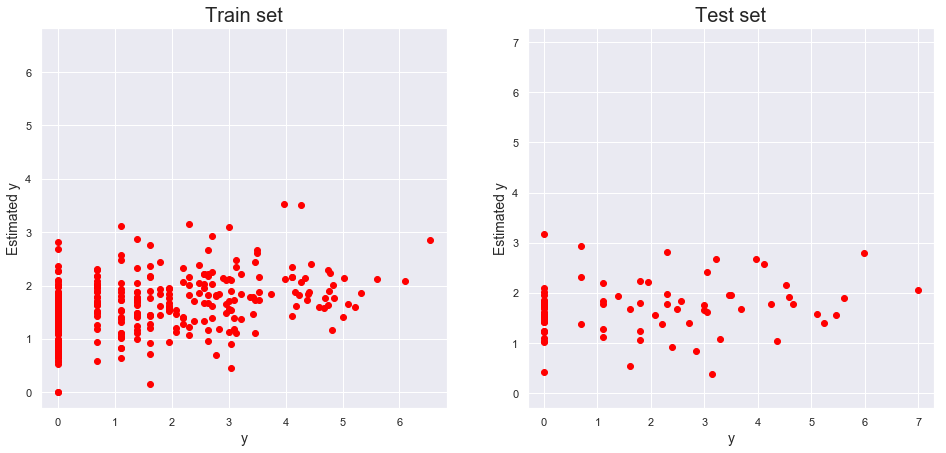

In [37]:
plot_yreal_ypred(y_test, y_train, X_test, X_train, model_regression)

__[1] Что видно по построенной картинке?__

__Ответ:__

## 3.3 Случайный лес

Давайте построим идеальную (нет) модель случайного леса, с выбором гиперпараметров по сетке. Объявим сетку гиперпараметров для перебора.

In [39]:
param_grid = [
  { 
    'random_state': range(5,45, 10),
    'max_depth': range(3,5),
    'criterion': ['mse', 'mae'], 
   'n_estimators': range(1,31,10)
  },
 ]

__[1] Что за гиперпараметры мо собрались перебирать? Опишите что они означают. Прочитать об этом можно в [документации](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)__

__Ответ:__ 

__[2] Оцените модель и подберите оптимальные гиперпараметры.__

In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

reg_forest = RandomForestRegressor()

grid_cv = GridSearchCV(reg_forest, 
                       param_grid, 
                       scoring = 'neg_mean_absolute_error', 
                       cv = 7)

In [41]:
grid_cv.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=7, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'criterion': ['mse', 'mae'], '

Давайте посмотрим, какие гиперпараметры у нас получились.

In [42]:
grid_cv.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=3,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=21,
                      n_jobs=None, oob_score=False, random_state=15, verbose=0,
                      warm_start=False)

__[1] Примените полученную модель на тестовой выборке и постройте функцию MAE и постройте визуализацию.__


In [43]:
y_reg_forest_pred = grid_cv.predict(X_test)

In [45]:
mae(y_test, y_reg_forest_pred)

1.4805767677589323

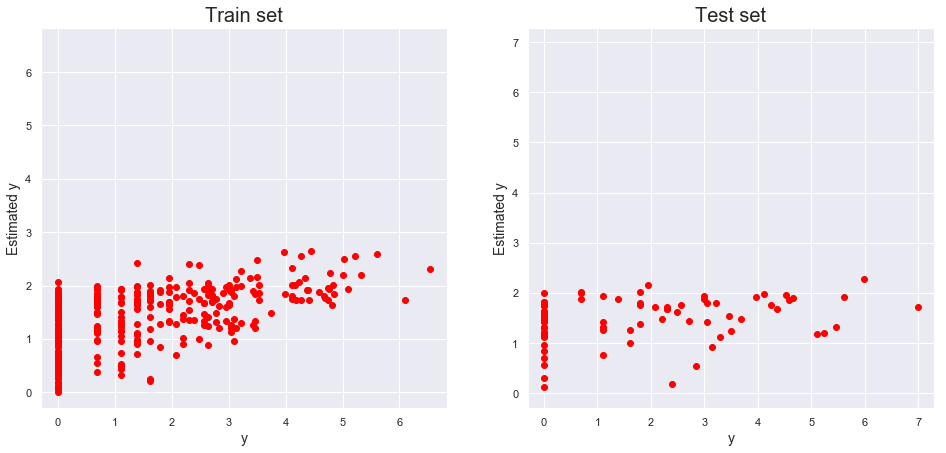

In [46]:
plot_yreal_ypred(y_test, y_train, X_test, X_train, grid_cv)

__[1] Какие модель оказалась лучшей? Побила ли она константный прогноз? Какие выводы можно сделать из визуализаций?__


__Ответ:__ 


__[1] Опишите что бы происходило на картинке, если бы модель переобучилась? Что происходило бы, если бы она получилась хорошей? Почему картинка выглядела бы именно так?__ 


__Ответ:__ 


__[1] Как считате, удалось ли нам научиться предсказывать, сколько лайков студент первого курса поставит в паблик? С чем это на ваш взгляд связано?__

__Ответ:__ 
 

Настрадался? Выскажи всё, что думаешь обо всём этом [в анонимке по пятому дз.](https://docs.google.com/forms/d/e/1FAIpQLSfqW8UBNNSQbqSm_y6pmoQdXi595iyDRkB66KuxXfmOjbxCaw/viewform) 